## Phase 1: Data Collection & Feature Engineering

c:\Users\DKS\Desktop\VSC\Nov25\conda-grib\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Fetching data for SI=F...
Data shape: (5031, 7)


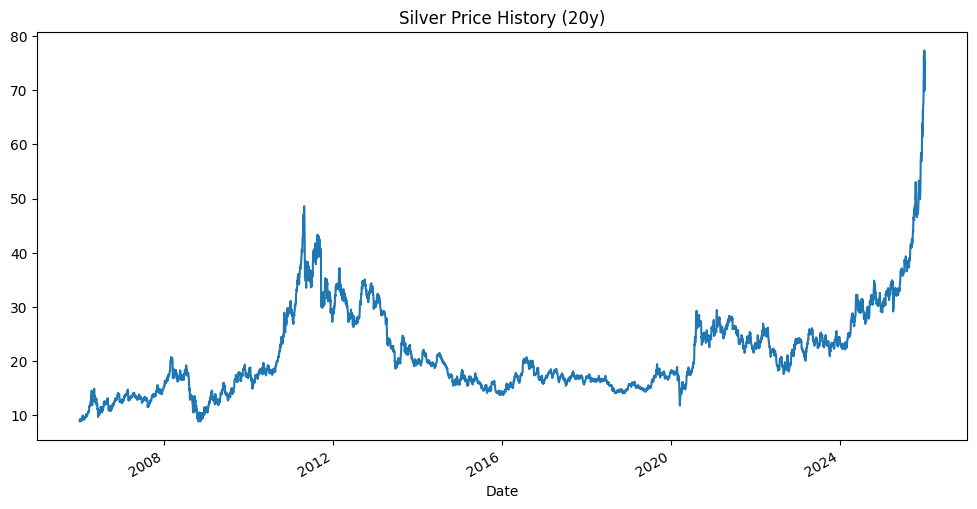

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Dropout

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

def fetch_data(ticker='SI=F', period='20y'):
    print(f"Fetching data for {ticker}...")
    df = yf.Ticker(ticker).history(period=period)
    return df

# 1. Fetch Data
df = fetch_data()
print(f"Data shape: {df.shape}")
df['Close'].plot(title='Silver Price History (20y)', figsize=(12,6))
plt.show()

## Phase 2: Exploratory Analysis & Visualization
We check for stationarity using the Augmented Dickey-Fuller (ADF) test and visualize rolling statistics.

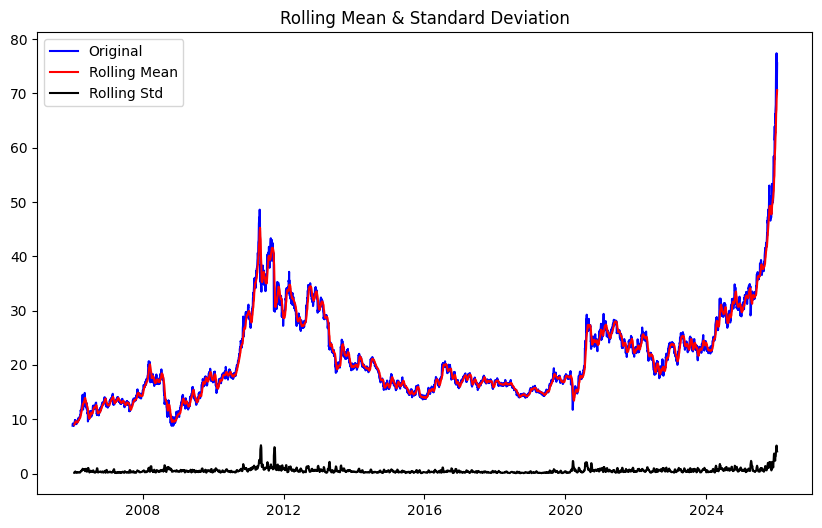

Results of Dickey-Fuller Test:
Test Statistic                    2.143734
p-value                           0.998833
#Lags Used                       32.000000
Number of Observations Used    4998.000000
Critical Value (1%)              -3.431659
Critical Value (5%)              -2.862118
Critical Value (10%)             -2.567078
dtype: float64


In [2]:
def test_stationarity(timeseries):
    # Rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(10,6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Dickey-Fuller Test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Close'])

## Phase 3: ARIMA Baseline Model
A simple ARIMA model to establish a baseline for performance.

Training ARIMA baseline (this may take a moment)...
ARIMA Baseline RMSE: 10.5580


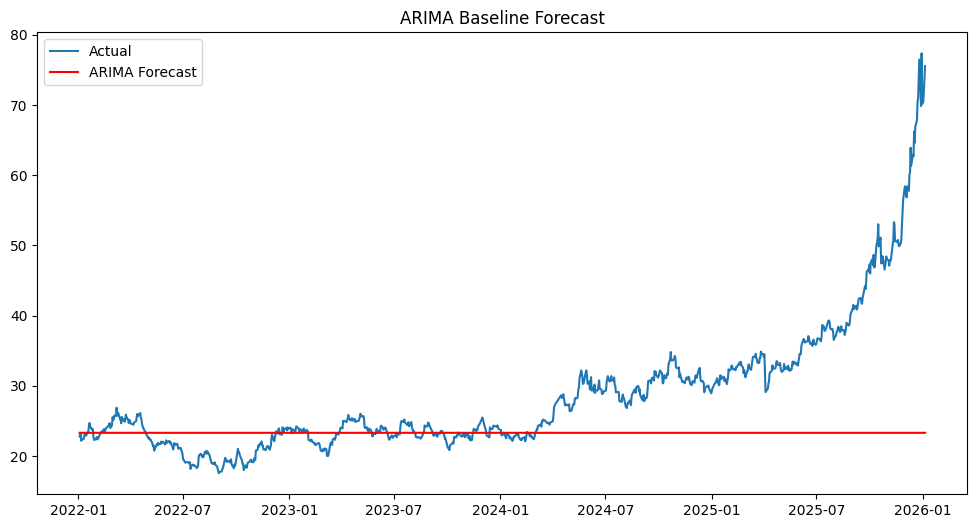

In [3]:
# Simple ARIMA on Close price
# Note: For a real rigorous ARIMA, we'd grid search (p,d,q). Here we use a standard config.
train_data, test_data = df['Close'][0:int(len(df)*0.8)], df['Close'][int(len(df)*0.8):]

history = [x for x in train_data]
predictions = []

# Walk-forward validation for ARIMA (simplified for speed)
print("Training ARIMA baseline (this may take a moment)...")
# We'll just forecast the test set in one go for speed in this demo, 
# or a small walk-forward loop.
model = ARIMA(history, order=(5,1,0))
model_fit = model.fit()
output = model_fit.forecast(steps=len(test_data))
predictions = output

rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f'ARIMA Baseline RMSE: {rmse:.4f}')

plt.figure(figsize=(12,6))
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, predictions, color='red', label='ARIMA Forecast')
plt.title('ARIMA Baseline Forecast')
plt.legend()
plt.show()

## Phase 4: Hybrid Deep Learning Model (CNN-LSTM-GRU)
Implementing the advanced architecture to capture spatial and temporal dependencies.

In [4]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def build_hybrid_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        GRU(units=64, return_sequences=False),
        Dropout(0.2),
        Dense(units=32, activation='relu'),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Preprocessing
data = df[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

SEQ_LENGTH = 60
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train
print("Training Hybrid Model...")
model = build_hybrid_model((X_train.shape[1], X_train.shape[2]))
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Training Hybrid Model...
Epoch 1/20


c:\Users\DKS\Desktop\VSC\Nov25\conda-grib\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0031 - val_loss: 7.6098e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.0768e-04 - val_loss: 7.7182e-04
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.1977e-04 - val_loss: 6.7604e-04
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.8035e-04 - val_loss: 7.1403e-04
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.7434e-04 - val_loss: 8.6876e-04
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.5950e-04 - val_loss: 5.4808e-04
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.0381e-04 - val_loss: 5.2259e-04
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.2057e-04 - val_loss: 5.0282e-04
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.5290e-04 - val_loss: 5.6970e-04
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.6571e-04 - val_loss: 5.7814e-04
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.

## Phase 5 & 6: Validation & Risk Metrics
Evaluating the model with standard metrics and visualizing performance.

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Hybrid Model Test MAE: 0.7149
Hybrid Model Test RMSE: 1.3264


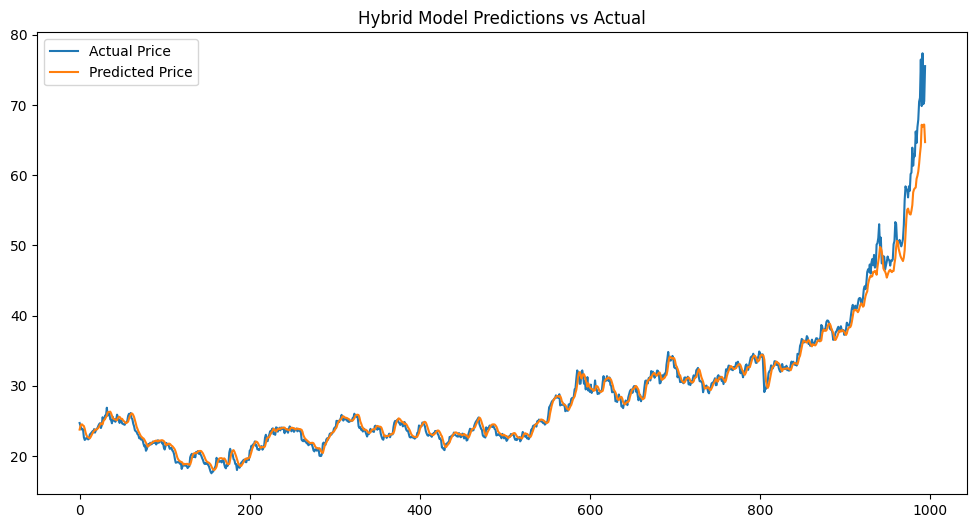

In [5]:
# Predictions
predictions = model.predict(X_test)
predictions_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test)

# Metrics
mae = mean_absolute_error(y_test_inv, predictions_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
print(f"Hybrid Model Test MAE: {mae:.4f}")
print(f"Hybrid Model Test RMSE: {rmse:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(predictions_inv, label='Predicted Price')
plt.title('Hybrid Model Predictions vs Actual')
plt.legend()
plt.show()

## Phase 7: Production Deployment & Forecasting
Generating the 30-day forecast.

                       Date  Predicted_Close
0 2026-01-06 00:00:00-05:00        65.547256
1 2026-01-07 00:00:00-05:00        64.342491
2 2026-01-08 00:00:00-05:00        60.595402
3 2026-01-09 00:00:00-05:00        57.723358
4 2026-01-12 00:00:00-05:00        55.086967


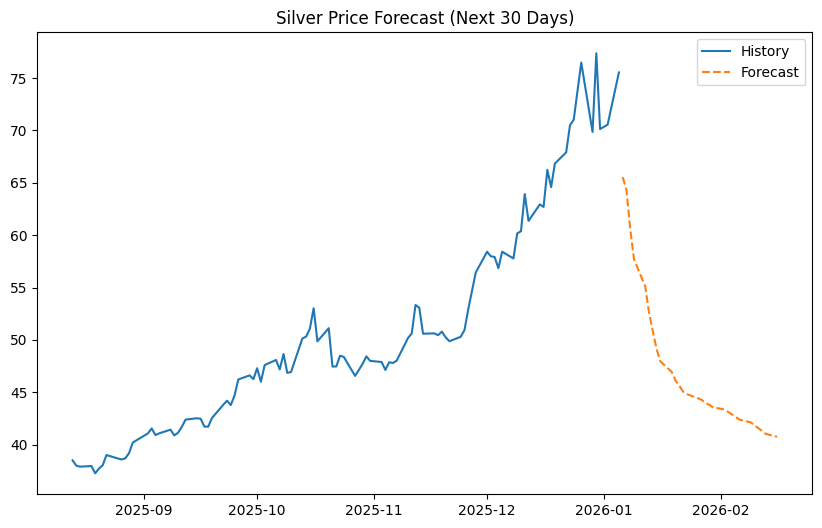

In [6]:
FORECAST_DAYS = 30
last_sequence = scaled_data[-SEQ_LENGTH:]
curr_seq = last_sequence.reshape((1, SEQ_LENGTH, 1))
future_predictions = []

for _ in range(FORECAST_DAYS):
    pred = model.predict(curr_seq, verbose=0)
    future_predictions.append(pred[0, 0])
    pred_reshaped = pred.reshape((1, 1, 1))
    curr_seq = np.append(curr_seq[:, 1:, :], pred_reshaped, axis=1)

future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create DataFrame
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=FORECAST_DAYS, freq='B')
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_predictions_inv.flatten()})

print(forecast_df.head())
forecast_df.to_csv('silver_price_forecast_hybrid.csv', index=False)

# Plot Forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index[-100:], df['Close'].tail(100), label='History')
plt.plot(forecast_df['Date'], forecast_df['Predicted_Close'], label='Forecast', linestyle='--')
plt.title(f'Silver Price Forecast (Next {FORECAST_DAYS} Days)')
plt.legend()
plt.show()